# BEHAVIORAL CLONING PROJECT

The aim of this project is to design a system that can drive a car autonomously in a simulated environment.

Our process is splitted into the following five steps:
1. **Data Collection**
    To train the model, we will use the sample data. Meanwhile, I will propose my strategies to collect data from simulator and attach my code for cleaning.
2. **Data Exploration and Augmentation.**
    * After checking the samples data's distribution, we find it is unbalanced. 
    * If we go further and check the images whose corresponding steering angles are bigger than 0.45. There are 81 samples in this range. However, we found there are at least 8 outliers, and 4 images whose steering angles need to be adjusted. This can well explain the reason why the car hit bridge during some of my first tries when I didn't use data augmentation. I also checked the images whose steering angles located in 0.4 and 0.45. There are 67 samples in total. But 7 of them are recommend to be removed.  
    * Therefore, data augmentation is necessary. Methods that will be used are as follows. 
        * First, all images from left, center and right cameras are used to train the model. Suppose the correction is 0.2. Denote the number of center images whose steering angles are located in the range (0.2, 0.4] N. After this step, we will obtain N new samples such that whose steering angles will locate in the range (0.4, 0.6].  
        * After the first step, accuracy of the trained model dropped, even if I changed   
    
2. **Build, a convolution neural network in Keras that predicts steering angles from images**
3. Train and validate the model with a training and validation set
4. Test that the model successfully drives around track one without leaving the road
5. Summarize the results with a written report

Links: 
* Simulators: [macOS](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f290_simulator-macos/simulator-macos.zip), [Windows 64-bit](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f3a4_simulator-windows-64/simulator-windows-64.zip), [Linux](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f0f7_simulator-linux/simulator-linux.zip)

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import os
from sklearn.model_selection import train_test_split

## DATA COLLECTION

In [2]:
data_dir = './data'
driving_log = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'))

X = driving_log[['center', 'left', 'right']].values
y = driving_log['steering'].values

## DATA VISUALIZATION

In [3]:
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### data distribution

(0, 40)

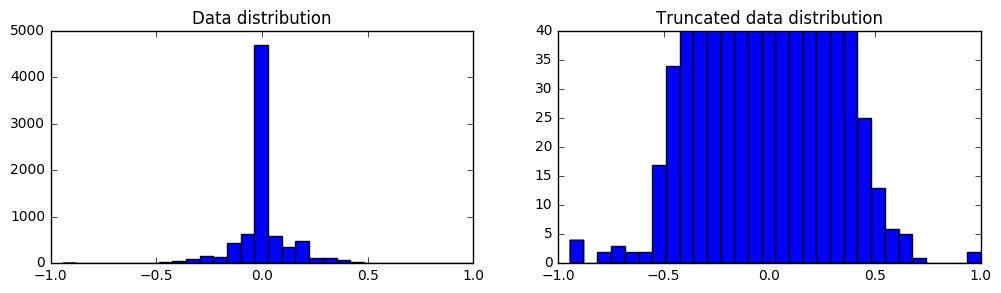

In [4]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(y, bins=30)
plt.title("Data distribution")
plt.subplot(1,2,2)
plt.hist(y, bins=30)
plt.title("Truncated data distribution")
plt.ylim(0,40)


I didn't go deeper of the data and show the outliers in the range [-1, -0.4) and (0.4, 1]. Because after the data augmentation its proportion becomes low. If the model is trained properly, those effect will 

### remove the outliers in the range (0.5, 1] and [-1, -0.5)

In [5]:
check_set = []
for i in range(len(y)):
    if abs(y[i]) > 0.5:
        check_set.append([i, y[i]])

print("In total, there are {} samples whose steering angles are in the range [-1, -0.5) or (0.5, 1].".format(len(check_set)))



In total, there are 44 samples whose steering angles are in the range [-1, -0.5) or (0.5, 1].


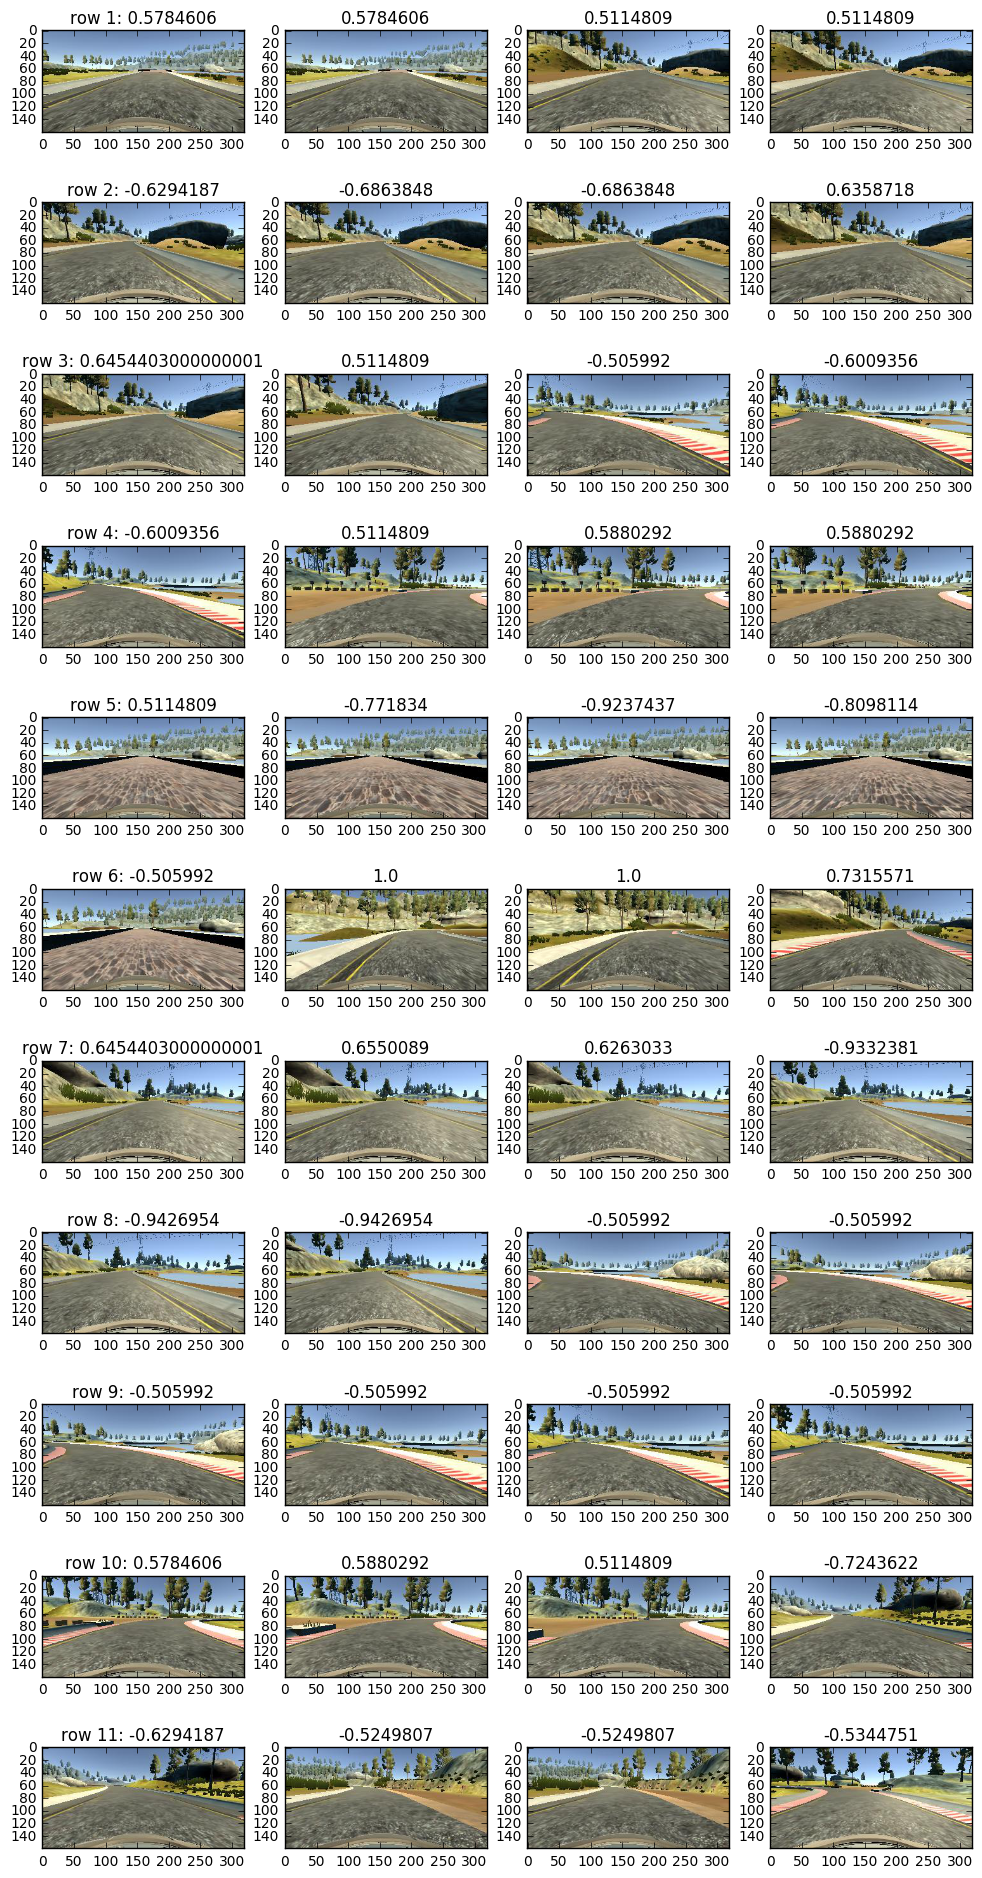

In [6]:
plt.figure(figsize=(12,24))
for i in range(len(check_set)):
    plt.subplot(11,4,i+1)
    row = i % 4
    image = mpimg.imread(os.path.join(data_dir, X[check_set[i][0]][0].strip()))
    plt.imshow(image)
    if row == 0:
        plt.title("row {}: {}".format(i//4 + 1, check_set[i][1]))
    else:
        plt.title(check_set[i][1])


It is not hard to find all images in row 5 and the first image of row 6 are outliers. We decide to remove them. The following formula is used to calculate their indexes.

(Row i, Col j) corresponding to the index (i - 1)* 4 + (j - 1)

In [7]:
remove_pre = [16, 17, 18, 19, 20]
remove_indexes = []
for i in range(len(remove_pre)):
    remove_indexes.append(check_set[remove_pre[i]][0])
print("The indexes of images that we are going to remove are: {}".format(remove_indexes))

# Remove outliers
X = np.delete(X, remove_indexes, 0)
y = np.delete(y, remove_indexes, 0)

The indexes of images that we are going to remove are: [3434, 3438, 3439, 3440, 3453]


#### Double check

print(type(X_new), type(y_new))
check_set2 = []

for i in range(len(y_new)):
    if abs(y_new[i]) > 0.5:
        check_set2.append([i, y_new[i]])

print(len(check_set2))
print(check_set2[0:3])

plt.figure(figsize=(12,20))
for i in range(len(check_set2)):
    plt.subplot(10,4,i+1)
    row = i % 4
    image = mpimg.imread(os.path.join(data_dir, X_new[check_set2[i][0]][0].strip()))
    plt.imshow(image)
    if row == 0:
        plt.title("row {}: {}".format(i//4 + 1, check_set2[i][1]))
    else:
        plt.title(check_set2[i][1])


In [8]:
stable_indexes = []
for i in range(len(y)):
    if abs(y[i]) < 0.05:
        stable_indexes.append(i)
print("There are {} samples in total whose steering angles are loacted in (-0.05, 0.05).".format(len(stable_indexes)))

remove_indexes = np.random.choice(stable_indexes, len(stable_indexes)*2//3)
#print(remove_indexes[0:10], len(remove_indexes))
X = np.delete(X, remove_indexes, 0)
y = np.delete(y, remove_indexes, 0)

There are 4881 samples in total whose steering angles are loacted in (-0.05, 0.05).


5661


(0, 40)

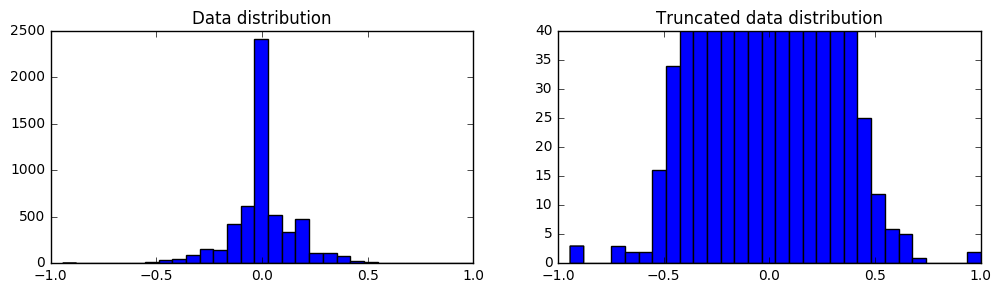

In [9]:
print(len(y))
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(y, bins=30)
plt.title("Data distribution")
plt.subplot(1,2,2)
plt.hist(y, bins=30)
plt.title("Truncated data distribution")
plt.ylim(0,40)

## DATA AUGMENTATION 
### use all images obtained from center, left and right cameras.

In [10]:
def choose_image(data_dir, center, left, right, steering_angle):
    trigger = np.random.choice(3)
    if trigger == 0:
        return mpimg.imread(os.path.join(data_dir, left.strip())), steering_angle + 0.2
    elif trigger == 1:
        return mpimg.imread(os.path.join(data_dir, right.strip())), steering_angle - 0.2
    return mpimg.imread(os.path.join(data_dir, center.strip())), steering_angle

### random flip

In [11]:
def random_flip(image, steering_angle):
    if np.random.choice(2):
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

### random shift

In [12]:
def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtically and horizontally
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1,0,trans_x], [0,1,trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

### random shadow

In [13]:
def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

### random brightness

In [14]:
def random_brightness(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    image_hsv[:,:,2] = image_hsv[:,:,2] * ratio
    return cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)

### data augmentation

In [15]:
def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

## PREPROCESSING

In [16]:
def crop(image):
    """
    Remove the unrelevant content from image
    """
    return image[60:140,:,:]

def resize(image):
    """
    In order to fit the input shape of NVIDIA model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

def rgb2yuv(image):
    """
    Will be used in the NVIDIA model
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def preprocess(image):
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image



index = np.random.choice(len(X_train), 1)[0]
center, left, right = X_train[index]
steering_angle = y_train[index]

image, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
image_pre = preprocess(image)
steering_angle_pre = steering_angle

plt.figure(figsize=(12, 3))
plt.imshow(image_pre)
plt.title(steering_angle_pre)

image_flib, steering_angle_flib = random_flip(image_pre, steering_angle)

plt.figure(figsize=(12, 3))
plt.imshow(image_flib)
plt.title(steering_angle_flib)

range_x = 100 
range_y = 10

image_translate, steering_angle_t = random_translate(image_pre, steering_angle, range_x, range_y)
plt.figure(figsize=(12, 3))
plt.imshow(image_translate)
plt.title(steering_angle_t)

image_shadow = random_shadow(image_pre)

plt.figure(figsize=(12, 3))
plt.imshow(image_shadow)
plt.title(steering_angle)

image_brightness = random_brightness(image_pre)

plt.figure(figsize=(12, 3))
plt.imshow(image_brightness)
plt.title(steering_angle)

index = np.random.choice(len(X_train), 1)[0]
print(len(X_train), index)
print(X_train[index])
print(data_dir)

center, left, right = X_train[index]
steering_angle = y_train[index]
print(steering_angle)

image_aug, steering_angle_aug = augument(data_dir, center, left, right, steering_angle)

plt.figure(figsize=(12, 3))
plt.imshow(image_aug)
plt.title(steering_angle_aug)

from sklearn.utils import shuffle

test_X = [1,2,3,4,5,6,7,8,9,10]
test_y = ['a', 'b', 'c', 'd', 'e',  'f', 'g', 'h', 'i', 'j']

test_X, test_y = shuffle(test_X, test_y, random_state=0)

print(test_X)
print(test_y)

print(X_train.shape[0])
print(len(X_train))

from sklearn.utils import shuffle


def batch_generator(data_dir, X, y, batch_size, is_training):
    """
    Generate training images given image paths (X) and associated steering angles (y)
    """
    
    num_data = len(X)//batch_size * batch_size
    while True:
        # shuffle before sampling
        X, y = shuffle(X, y)
        for offset in range(0, num_data, batch_size):
            images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
            angles = np.empty(batch_size)
            
            X_batch = X[offset:offset+batch_size]
            y_batch = y[offset:offset+batch_size]
            
            for i in range(batch_size):
                center, left, right = X_batch[i]
                steering_angle = y_batch[i]
                # augmentation
                if is_training and np.random.rand() < 0.6:
                    image, steering_angle = augument(data_dir, center, left, right, steering_angle)
                else:
                    image = mpimg.imread(os.path.join(data_dir, center.strip()))
                # add the image and steering angle to the batch
                images[i] = preprocess(image)
                angles[i] = steering_angle
            
            yield shuffle(images, angles)

def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

## CREATE DATA PARTITION

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 123)


NOTES. On the first glance, we split the data based on an imbalanced data. The truth is the split data will be augumented during batch generation.

## PARAMETERS

In [18]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

LEARNING_RATE = 0.0001
# The default learning rate of the optimizer Adam is 0.001, which is too big and made the validation loss 
# stop improving too early.

EPOCHS = 10
# 

In [19]:
def batch_generator(data_dir, image_paths, steering_angles, batch_size):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if np.random.rand() < 0.7:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                #image = load_image(data_dir, center) 
                image = mpimg.imread(os.path.join(data_dir, center.strip()))
            # add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

X_test, y_test = X_train[0:2], y_train[0:2]

images_test = np.empty([2, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
angles_test = np.empty(2)

for i in range(2):
    center, left, right = X_test[i]
    steering_angle_test = y_test[i]
    if 1 and np.random.rand() < 0.6:
        image_test, steering_angle_test = augument(data_dir, center, left, right, steering_angle_test)
    else:
        image_test = mpimg.imread(os.path.join(data_dir, center.strip()))
    images_test[i] = preprocess(image_test)
    angles_test[i] = steering_angle_test

plt.figure(figsize=(12,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images_test[i])
    plt.title(angles_test[i])

In [20]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, MaxPooling2D, Dropout, Dense, Flatten
from keras.layers.convolutional import Convolution2D

drop_prob = 0.5
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape = INPUT_SHAPE))
#model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape = INPUT_SHAPE))
model.add(Convolution2D(24, 5, 5, activation = 'relu', subsample = (2, 2)))
model.add(Convolution2D(36, 5, 5, activation = 'relu', subsample = (2, 2)))
model.add(Convolution2D(48, 5, 5, activation = 'relu', subsample = (2, 2)))
model.add(Convolution2D(64, 3, 3, activation = 'relu'))
model.add(Convolution2D(64, 3, 3, activation = 'relu'))
model.add(Dropout(drop_prob))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50,  activation = 'relu'))
model.add(Dense(10,  activation = 'relu'))
model.add(Dense(1))

model.summary()


Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_2[0][0]            
___________________________________________________________________________________________

Epoch 1/10


//anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 66


19968/20000 [============================>.] - ETA: 0s - loss: 0.0341

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


20032/20000 [==============================] - 330s - loss: 0.0340 - val_loss: 0.0268
Epoch 2/10
20032/20000 [==============================] - 312s - loss: 0.0256 - val_loss: 0.0227
Epoch 3/10
20032/20000 [==============================] - 266s - loss: 0.0214 - val_loss: 0.0185
Epoch 4/10
20032/20000 [==============================] - 261s - loss: 0.0189 - val_loss: 0.0170
Epoch 5/10
20032/20000 [==============================] - 319s - loss: 0.0186 - val_loss: 0.0178
Epoch 6/10
20032/20000 [==============================] - 308s - loss: 0.0181 - val_loss: 0.0181
Epoch 7/10
20032/20000 [==============================] - 271s - loss: 0.0175 - val_loss: 0.0166
Epoch 8/10
20032/20000 [==============================] - 261s - loss: 0.0174 - val_loss: 0.0166
Epoch 9/10
20032/20000 [==============================] - 269s - loss: 0.0170 - val_loss: 0.0167
Epoch 10/10
20032/20000 [==============================] - 324s - loss: 0.0174 - val_loss: 0.0185
dict_keys(['loss', 'val_loss'])


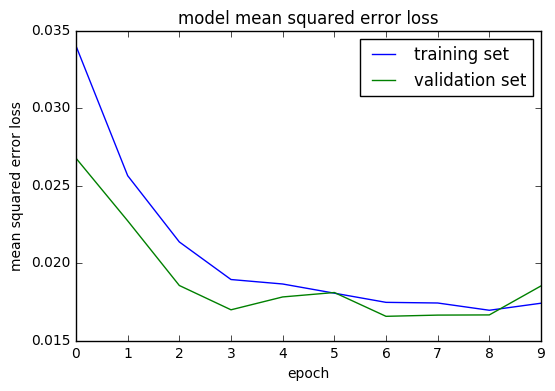

In [21]:

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=True,
                            mode='auto')

model.compile(loss='mse', optimizer=Adam(lr=LEARNING_RATE))

history_object = model.fit_generator(batch_generator(data_dir, X_train, y_train, 64),
                                     samples_per_epoch = 20000,
                                     nb_epoch = EPOCHS,
                                     max_q_size = 1,
                                     validation_data=batch_generator(data_dir, X_valid, y_valid, 64),
                                     nb_val_samples = len(X_valid),
                                     callbacks=[checkpoint],
                                     verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

Notes. 1. we should also consider data augmentation when validation

2. make clear the reason: 

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 66

3. 